In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import sklearn.datasets
import umap
import umap.plot

from skimage.segmentation import slic, quickshift
from skimage.segmentation import mark_boundaries

from models import *

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')   
    

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [54]:
no_samples, rows, cols, channels = trainset.data.shape
umap_data = trainset.data.reshape((no_samples,rows*cols*channels))
mapper = umap.UMAP(n_components=3, random_state=21).fit(umap_data)
# umap.plot.points(mapper, labels= np.array(trainset.targets))

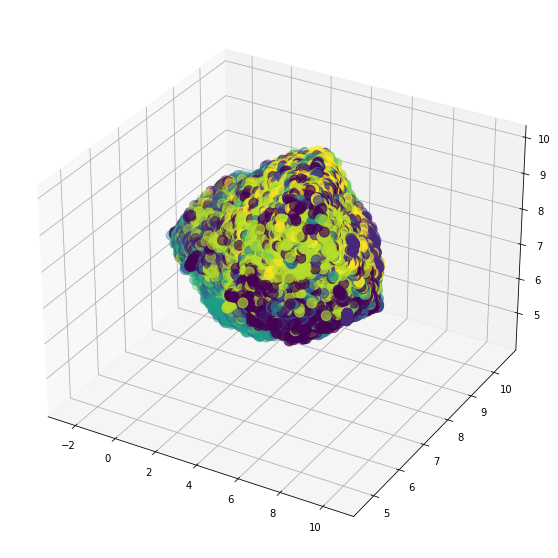

In [58]:
u = mapper.transform(umap_data)

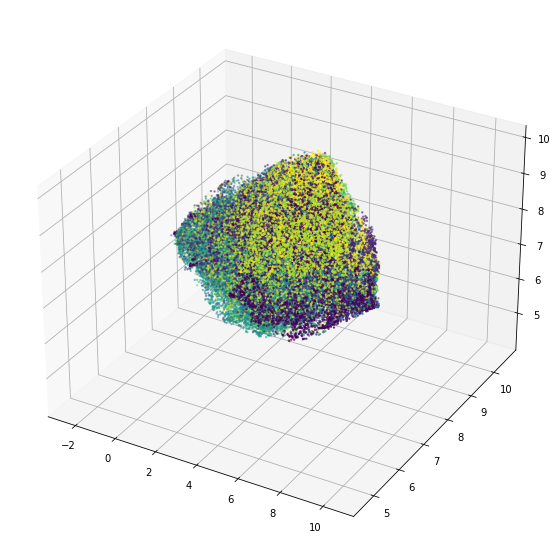

In [60]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(u[:,0], u[:,1], u[:,2], c=np.array(trainset.targets), s=2)

In [61]:
ex_loader = torch.utils.data.DataLoader(testset, batch_size=10)
ex_batch = next(iter(ex_loader))
ex_images, ex_labels = ex_batch
print(type(ex_images), type(ex_labels))
print(ex_images.shape, ex_labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 3, 32, 32]) torch.Size([10])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SLIC number of segments: 12


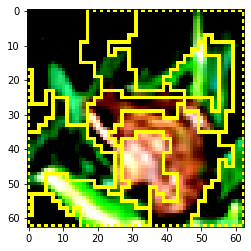

In [62]:
sample_idx = 4

ex_img = ex_images[sample_idx]

def segment_img(torch_img, n_segments=10, compactness=2, sigma=1, start_label=0):
    np_img = torch_img.numpy()
    np_img = np.swapaxes(np_img,0,1)
    np_img = np.swapaxes(np_img,1,2)
    segments_slic = slic(np_img, n_segments=n_segments, compactness=compactness,
                         sigma=sigma, start_label=start_label)
    return np_img, segments_slic

np_img, segments_slic = segment_img(ex_img,n_segments=20, compactness=2, sigma=1)

plt.imshow(mark_boundaries(np_img, segments_slic, mode = 'subpixel'))
print(f"SLIC number of segments: {len(np.unique(segments_slic))}")
feature_mask = torch.from_numpy(segments_slic)

In [ ]:
inv_transformed_points = mapper.inverse_transform(test_pts)

In [63]:
mapper.transform(ex_img.reshape((1,rows*cols*channels)))

array([[-2.405715 ,  8.257797 ,  6.7645802]], dtype=float32)

In [65]:
mapper.inverse_transform([[-2.405715 ,  8.257797 ,  6.7645802]])

array([[60.15113 , 31.627588, 39.365505, ..., 76.50166 , 66.75122 ,
        42.466816]], dtype=float32)

In [69]:
mapper.transform(inv_ex_img.reshape((1,rows*cols*channels)))

array([[-1.6500618,  8.472689 ,  6.9913583]], dtype=float32)

In [66]:
inv_ex_img = mapper.inverse_transform(mapper.transform(ex_img.reshape((1,rows*cols*channels))))
inv_ex_img = inv_ex_img.reshape((channels,rows,cols))

In [67]:
inv_np_img  = np.swapaxes(inv_ex_img,0,1)
inv_np_img = np.swapaxes(inv_np_img,1,2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


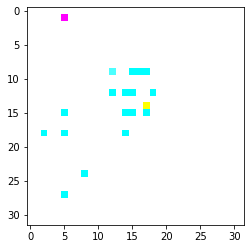

In [68]:
plt.imshow(inv_np_img)